In [10]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')


In [11]:
# Aggregate transaction data for clustering
transactions_agg = transactions.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    num_transactions=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean")
).reset_index()

# Merge with customer profile data
customer_profiles = customers.merge(transactions_agg, on="CustomerID", how="left").fillna({
    'total_spent': 0,
    'num_transactions': 0,
    'avg_transaction_value': 0
})


In [12]:
# One-hot encode categorical columns (if any, e.g., Region)
customer_profiles = pd.get_dummies(customer_profiles, columns=["Region"], drop_first=True)

# Select features for clustering
feature_columns = ['total_spent', 'num_transactions', 'avg_transaction_value']
features = customer_profiles[feature_columns]


In [13]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply clustering using KMeans
cluster_range = range(2, 11)
db_scores = []
kmeans_models = []

In [14]:
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)
    db_index = davies_bouldin_score(features_scaled, cluster_labels)
    db_scores.append(db_index)
    kmeans_models.append(kmeans)

In [15]:
# Find the optimal number of clusters (lowest DB Index)
optimal_k = cluster_range[np.argmin(db_scores)]
optimal_model = kmeans_models[np.argmin(db_scores)]

# Assign cluster labels to customers
customer_profiles['Cluster'] = optimal_model.labels_

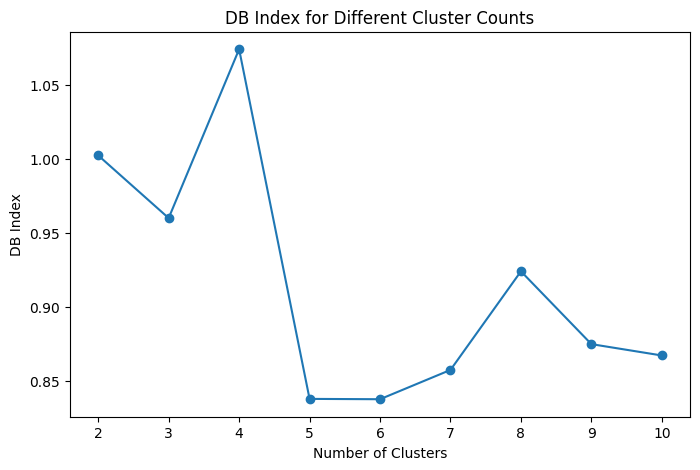

In [16]:
# Save cluster assignment to a CSV
customer_profiles.to_csv("Customer_Segmentation.csv", index=False)

# Visualize DB Index values for different cluster counts
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, db_scores, marker='o')
plt.title("DB Index for Different Cluster Counts")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.xticks(cluster_range)
plt.show()

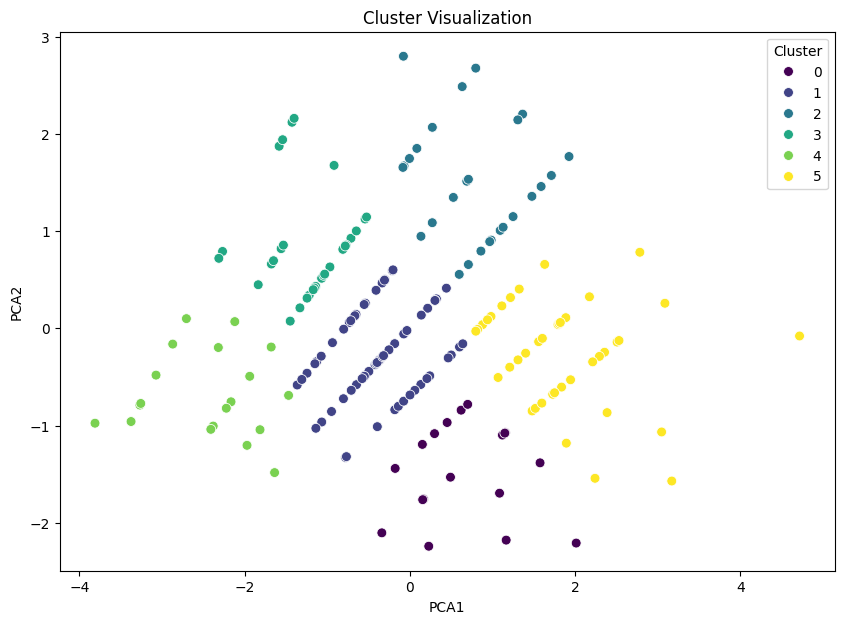

In [17]:
# Visualize clusters (2D plot for simplicity)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_scaled)
reduced_df = pd.DataFrame(reduced_features, columns=["PCA1", "PCA2"])
reduced_df['Cluster'] = optimal_model.labels_

plt.figure(figsize=(10, 7))
sns.scatterplot(data=reduced_df, x="PCA1", y="PCA2", hue="Cluster", palette="viridis", s=50)
plt.title("Cluster Visualization")
plt.show()

In [18]:
print(customer_profiles.head())

  CustomerID        CustomerName  SignupDate  Month  total_spent  \
0      C0001    Lawrence Carroll  2022-07-10      7      3354.52   
1      C0002      Elizabeth Lutz  2022-02-13      2      1862.74   
2      C0003      Michael Rivera  2024-03-07      3      2725.38   
3      C0004  Kathleen Rodriguez  2022-10-09     10      5354.88   
4      C0005         Laura Weber  2022-08-15      8      2034.24   

   num_transactions  avg_transaction_value  Region_Europe  \
0               5.0                670.904          False   
1               4.0                465.685          False   
2               4.0                681.345          False   
3               8.0                669.360          False   
4               3.0                678.080          False   

   Region_North America  Region_South America  Cluster  
0                 False                  True        1  
1                 False                 False        1  
2                 False                  True        